In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


from poclaps.train.ppo import reload

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

I0000 00:00:1731854700.130938 1387904 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


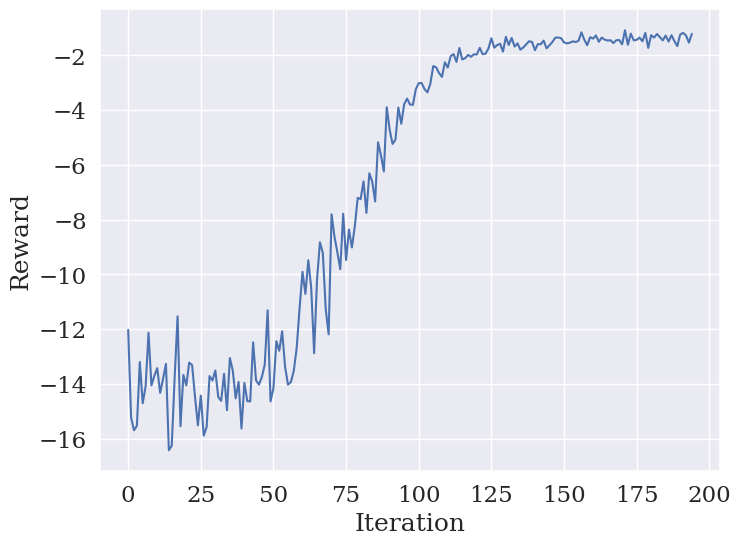

reformatted figures/prelim_run_results/policy_training_history/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [2]:
import pandas as pd
from reproducible_figures import save_reproducible_figure, set_plotting_style
import matplotlib.pyplot as plt


policy_training_metrics = pd.read_csv(f'{policy_dir}/metrics.csv')

def plot_policy_training_history(policy_training_metrics):
    set_plotting_style(font_scale=1.5)
    _, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(policy_training_metrics['iteration'], policy_training_metrics['mean_reward'])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Reward')


save_reproducible_figure(
    'policy_training_history', 
    policy_training_metrics, 
    plot_policy_training_history, 
    show=True,
    figures_dir='figures/prelim_run_results'
)

In [3]:
import jax
import numpy as np
from poclaps.rollout_fake_msgs import rollout_with_msgs


N_ACTIONS = env.action_space(env_params).n


def sample_obs_modelling_batch(rng,
                               noise_dim: int = 64,
                               rollout_steps: int = 500,
                               action_sample_temp: float = 1.0,
                               return_traj: bool = False):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, metrics = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng,
        action_sample_temp=action_sample_temp,
    )

    n_msgs = env_params.grid_size * env_params.grid_size
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs = jax.nn.one_hot(traj_batch.message, n_msgs)

    *batch_shape, _ = traj_batch.obs.shape
    noise = jax.random.normal(rng, (*batch_shape, noise_dim))
    inputs = (actions, msgs, noise, traj_batch.obs, traj_batch.done)
    if return_traj:
        return inputs, metrics, traj_batch
    return inputs, metrics

In [4]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=5)
actions, msgs, noise, obs, dones = inputs

In [5]:
T = 4
actions[:T, 0].argmax(-1), msgs[:T, 0].argmax(-1), dones[:T, 0], obs[:T, 0].reshape(-1, 2, 2, 5).argmax(-1)

(Array([1, 1, 4, 1], dtype=int32),
 Array([17, 17, 17, 17], dtype=int32),
 Array([False, False, False,  True], dtype=bool),
 Array([[[0, 4],
         [1, 1]],
 
        [[0, 3],
         [1, 1]],
 
        [[0, 2],
         [1, 1]],
 
        [[1, 2],
         [1, 1]]], dtype=int32))

In [6]:
from typing import Iterable
from poclaps.simple_gridworld_game import stringify_grid


def get_goals_and_pos(obs):
    """
    Args:
        obs: (T, n_envs, 20) shaped array of observations.
    Returns:
        goal_pos: (T, n_envs, 2) shaped array of goal positions.
        agent_pos: (T, n_envs, 2) shaped array of agent positions.
    """
    *batch_shape, _ = obs.shape
    env_states = obs.reshape((*batch_shape, 2, 2, 5)).argmax(-1)

    agent_pos = env_states[:, :, 0]
    goal_pos = env_states[:, :, 1]

    return goal_pos, agent_pos


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p): 'X', tuple(g): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))

goal_pos, agent_pos = get_goals_and_pos(obs[:T, 0])
print_episode(goal_pos.tolist(), agent_pos.tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
| X |   |   |   | G |	| X |   |   | G |   |	| X |   | G |   |   |	|   | X | G |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [7]:
inputs, _ = sample_obs_modelling_batch(jax.random.PRNGKey(0), rollout_steps=500)
actions, msgs, noise, obs, dones = inputs
obs.shape, actions.shape
start_obs, next_obs = obs[:-1], obs[1:]
actions = actions[:-1]

In [8]:
actions.shape, start_obs.shape, next_obs.shape

((499, 4, 5), (499, 4, 20), (499, 4, 20))

In [9]:
import flax.linen as nn
import jax.numpy as jnp
import functools


class TransitionModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, inputs):
        """
        Args:
            obs: (B, D)
            action: (B, A)
        """
        actions, obs = inputs
        x = jnp.concatenate([obs, actions], axis=-1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

transition_model = TransitionModel(start_obs.shape[-1])

inputs = (actions, start_obs)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)

pred_obs = transition_model.apply(init_params, inputs)
pred_obs.shape

(499, 4, 20)

In [10]:
from poclaps.train.losses import categorical_cross_entropy


def obs_loss_fn(act_obs, pred_obs_logits):
    n_steps, n_envs, obs_dim = act_obs.shape
    act_env_state = act_obs.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))
    pred_env_state = pred_obs_logits.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))

    # 1h vecs for actual positions
    act_agent_pos_x = act_env_state[:, :, 0, 0]
    act_agent_pos_y = act_env_state[:, :, 0, 1]
    act_goal_pos_x = act_env_state[:, :, 1, 0]
    act_goal_pos_y = act_env_state[:, :, 1, 1]

    # 1h vecs for predicted positions
    pred_agent_pos_x = pred_env_state[:, :, 0, 0]
    pred_agent_pos_y = pred_env_state[:, :, 0, 1]
    pred_goal_pos_x = pred_env_state[:, :, 1, 0]
    pred_goal_pos_y = pred_env_state[:, :, 1, 1]

    # CCE loss for positions
    cce_x = categorical_cross_entropy(pred_agent_pos_x, act_agent_pos_x)
    cce_y = categorical_cross_entropy(pred_agent_pos_y, act_agent_pos_y)
    cce_goal_x = categorical_cross_entropy(pred_goal_pos_x, act_goal_pos_x)
    cce_goal_y = categorical_cross_entropy(pred_goal_pos_y, act_goal_pos_y)

    return cce_x + cce_y + cce_goal_x + cce_goal_y

obs_loss_fn(act_obs=next_obs, pred_obs_logits=pred_obs)

Array([[6.3642464, 6.3394895, 6.6845865, 5.7896113],
       [6.874488 , 6.6926756, 7.018973 , 6.0660753],
       [6.318925 , 5.830632 , 7.281263 , 6.5533857],
       ...,
       [6.4623075, 6.8881254, 6.4147673, 6.6458693],
       [6.8159566, 6.392277 , 6.6540666, 6.2438498],
       [6.59458  , 6.508105 , 6.231048 , 6.2669954]], dtype=float32)

In [11]:
from flax.training.train_state import TrainState
import optax
import chex

N_ROLLOUT_STEPS = 500
N_TRAIN_STEPS = 300


def process_inps(batch):
    actions, msgs, noise, obs, dones = batch
    start_obs, next_obs = obs[:-1], obs[1:]
    actions = actions[:-1]
    dones_mask = 1.0 - dones[:-1]
    return (actions, start_obs), next_obs, dones_mask


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, batch):
        inputs, next_obs, dones_mask = process_inps(batch)
        next_obs_preds_logits = train_state.apply_fn(params, inputs)
        loss_vals = dones_mask * obs_loss_fn(next_obs, next_obs_preds_logits)
        return loss_vals.mean()

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)

rng, _rng = jax.random.split(rng)
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=N_ROLLOUT_STEPS)
*_, obs, _ = batch
transition_model = TransitionModel(obs.shape[-1])

inputs, *_ = process_inps(batch)
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)
optimizer = optax.adam(1e-3)
transition_model_train_state = TrainState.create(
    apply_fn=transition_model.apply,
    params=init_params,
    tx=optimizer
)

(transition_model_train_state, _), metrics = jax.lax.scan(
    update_fn, (transition_model_train_state, rng), None, length=N_TRAIN_STEPS
)

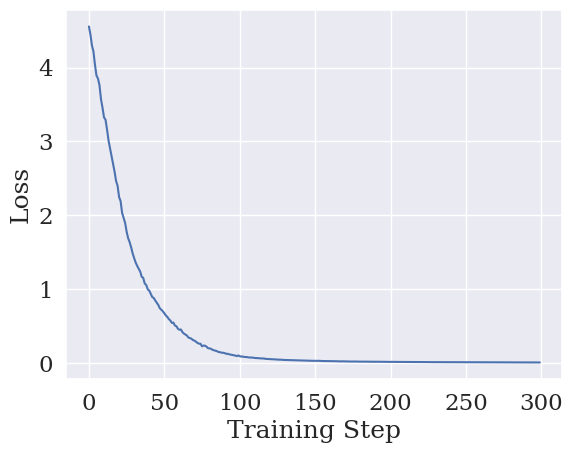

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from reproducible_figures import save_reproducible_figure, set_plotting_style

def plot(df):
    set_plotting_style()
    ax = sns.lineplot(df, x='step', y='loss')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': np.arange(metrics['loss'].size)
})

# save_reproducible_figure('transition_model_loss', df, plot, show=True)

plot(df)

In [14]:
TEST_STEPS = 500
batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
inputs, next_obs, dones_mask = process_inps(batch)

In [15]:
next_obs.shape

(499, 4, 20)

In [16]:
next_goals_pos, next_agent_pos = get_goals_and_pos(next_obs)
next_goals_pos.shape, next_goals_pos[0]

((499, 4, 2),
 Array([[3, 3],
        [3, 2],
        [2, 4],
        [2, 4]], dtype=int32))

In [17]:
def logits_to_real_obs(logits, n_envs=4, temp=0.1):
    env_states = logits.reshape((-1, n_envs, 2, 2, 5))

    agent_pos_x = env_states[:, :, 0, 0]
    agent_pos_y = env_states[:, :, 0, 1]
    goal_pos_x = env_states[:, :, 1, 0]
    goal_pos_y = env_states[:, :, 1, 1]

    return jnp.concatenate(
        [
            jax.nn.softmax(agent_pos_x / temp),
            jax.nn.softmax(agent_pos_y / temp),
            jax.nn.softmax(goal_pos_x / temp),
            jax.nn.softmax(goal_pos_y / temp)
        ], axis=-1
    )

In [18]:
pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
pred_next_obs = logits_to_real_obs(pred_next_obs_logits)

In [19]:
precision = 5
n_correct = (dones_mask * (next_obs == pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [20]:
pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
# pred_next_obs = logits_to_real_obs(pred_next_obs_logits)[0].round()
pi, *_ = pretrained_policy(obs)
pred_act = pi.sample(seed=jax.random.PRNGKey(0))
inputs = (jax.nn.one_hot(pred_act, 5), pred_next_obs)

In [21]:
inputs[0][0]

Array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [22]:
def compute_compounding_obs_preds(obs, inps, temp=0.1):
    act_next_obs, dones_mask, actions = inps
    # pi, *_ = pretrained_policy(obs)
    # pred_act = pi.sample(seed=jax.random.PRNGKey(0))
    # inputs = (jax.nn.one_hot(pred_act, 5), pred_obs)
    inputs = (actions, obs)
    pred_next_obs_logits = transition_model.apply(transition_model_train_state.params, inputs)
    pred_next_obs = logits_to_real_obs(pred_next_obs_logits, temp=temp)[0]

    next_obs = jnp.where(
        (dones_mask == 0)[:, None], act_next_obs, pred_next_obs
    )

    return next_obs, pred_next_obs

batch, _ = sample_obs_modelling_batch(_rng, rollout_steps=TEST_STEPS)
(action, obs), next_obs, dones_mask = process_inps(batch)

In [23]:
_, compounded_pred_next_obs = jax.lax.scan(
    compute_compounding_obs_preds, obs[0], (next_obs, dones_mask, action)
)

precision = 5
n_correct = (dones_mask * (next_obs == compounded_pred_next_obs.round(precision)).all(axis=-1)).sum()
accuracy = n_correct.sum() / dones_mask.sum()
accuracy

Array(1., dtype=float32)

In [24]:
T = 4
ENV_IDX = 1
print(dones_mask[:T, ENV_IDX])
goal_pos, agent_pos = get_goals_and_pos(pred_next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

[1. 1. 0. 1.]
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G | X |	|   |   |   | G |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [25]:
T = 4
goal_pos, agent_pos = get_goals_and_pos(next_obs[:T])
print_episode(goal_pos[:, ENV_IDX].tolist(), agent_pos[:, ENV_IDX].tolist())

---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   | X |	|   |   |   |   |   |	|   |   |   |   | G |	|   |   |   |   | G |
---------------------	---------------------	---------------------	---------------------
|   |   |   | G |   |	|   |   |   | G | X |	|   | X |   |   |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
			


In [26]:
def actions_preds_loss(obs_preds, true_actions):
    pred_action_dist, _ = pretrained_policy(obs_preds)
    return categorical_cross_entropy(
        pred_action_dist.logits, true_actions
    ).mean()


actions_preds_loss(compounded_pred_next_obs, action)

Array(1.6535125, dtype=float32)

In [27]:
def actions_preds_acc(obs_preds, true_actions):
    pred_action_dist, _ = pretrained_policy(obs_preds)
    pred_actions = pred_action_dist.logits.argmax(-1)
    return (pred_actions == true_actions.argmax(-1)).mean()


actions_preds_acc(compounded_pred_next_obs, action)

Array(0.41883767, dtype=float32)

In [28]:
import jax


def sample_init_obs_batch(rng,
                          noise_dim: int = 64,
                          batch_size: int = 512):
    noise_rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, batch_size)
    init_obs, _ = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)
    noise = jax.random.normal(noise_rng, (batch_size, noise_dim))
    return noise, init_obs

In [29]:
sample_init_obs_batch(jax.random.PRNGKey(0), batch_size=2)

(Array([[-0.09888369,  2.506235  ,  0.7709646 , -2.566372  , -1.056678  ,
         -0.08589505, -1.1263483 , -1.4746587 ,  1.0176736 , -0.08870202,
         -2.2064896 , -1.8556206 , -0.42565253, -1.2255049 , -1.0866312 ,
          1.1943948 ,  0.40512082, -1.7767317 ,  1.7513275 ,  1.5189085 ,
          0.87630486,  0.39879364,  0.6973779 ,  0.12441269,  0.5953105 ,
          1.0668632 , -0.2580644 , -0.5771248 ,  0.9866648 ,  1.110345  ,
         -0.6736215 , -0.9863035 ,  0.14894868, -1.08898   , -0.03916076,
         -0.6194477 ,  0.3279911 ,  0.5261584 ,  1.226813  ,  1.2293104 ,
          1.6715007 , -0.58628327,  1.7278807 ,  0.32560784,  0.75145096,
         -0.970783  ,  0.15815397,  0.52384853, -0.6927399 ,  1.363632  ,
          1.0026302 ,  0.9920616 , -0.09005146,  1.4980816 ,  0.0134411 ,
         -0.17539886,  1.4234868 , -0.90153   ,  0.5668088 , -0.35222855,
          0.03952095,  1.1127486 , -0.0499901 , -2.106966  ],
        [ 0.14152686,  0.8560746 , -0.6304051 , -0

In [18]:
class InitObsModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, noise):
        """
        Args:
            noise: (B, D)
        """
        x = nn.Dense(self.hidden_dim)(noise)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

In [19]:
# from flax.training.train_state import TrainState
# import optax
# import chex

# BATCH_SIZE = 512
# N_TRAIN_STEPS = 300


# @jax.jit
# def update_fn(state: tuple, _):
#     train_state, rng = state

#     def compute_loss(params, batch):
#         noise, obs = batch
#         obs_preds_logits = train_state.apply_fn(params, noise)
#         obs = obs.reshape((BATCH_SIZE, 1, -1))
#         obs_preds_logits = obs_preds_logits.reshape((BATCH_SIZE, 1, -1))
#         loss_vals = obs_loss_fn(obs, obs_preds_logits)
#         return loss_vals.mean()

#     rng, _rng = jax.random.split(rng)
#     batch = sample_init_obs_batch(_rng, batch_size=BATCH_SIZE)
#     loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
#     new_train_state = train_state.apply_gradients(grads=grads)
#     metrics = {'loss': loss}
#     return (new_train_state, rng), metrics


# rng = jax.random.PRNGKey(0)

# rng, _rng = jax.random.split(rng)
# noise, obs = sample_init_obs_batch(_rng, batch_size=BATCH_SIZE)
# init_obs_model = InitObsModel(obs.shape[-1])
# rng, _rng = jax.random.split(rng)
# init_params = init_obs_model.init(_rng, noise)
# optimizer = optax.adam(1e-3)
# init_obs_train_state = TrainState.create(
#     apply_fn=init_obs_model.apply,
#     params=init_params,
#     tx=optimizer
# )

# (init_obs_train_state, _), metrics = jax.lax.scan(
#     update_fn, (init_obs_train_state, rng), None, length=N_TRAIN_STEPS
# )

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# sns.set_theme()

# df = pd.DataFrame({
#     'loss': metrics['loss'],
#     'step': np.arange(metrics['loss'].size)
# })

# sns.lineplot(df, x='step', y='loss')
# plt.show()

In [20]:
# rng = jax.random.PRNGKey(0)
# rng, _rng = jax.random.split(rng)
# noise, _ = sample_init_obs_batch(_rng, batch_size=5)
# init_obs_pred = init_obs_model.apply(init_obs_train_state.params, noise)

In [21]:
# init_obs_pred.round(2)

In [22]:
def create_rollout_state_with_fixed_goal_pos(rng, n_seqs):
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    rng, _rng = jax.random.split(rng)
    set_goal_pos = jax.random.randint(_rng, (2,), 0, env.grid_size)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(set_goal_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    return (env_state, obsv, rng, ep_ids)


def sample_sequences(rng,
                     n_seqs=64,
                     seq_len=8,
                     comm_policy_seed=0,
                     rollout_state=None,
                     action_sample_temp: float = 1.0,
                     fix_goal_pos_in_batch: bool = False):
    """
    Returns:
        (actions_1h, msgs_1h, seq_mask): 1h vectors for actions and messages,
            and a mask for sequences.
        obs: (T, n_envs, 20) shaped array of observations.
    """

    rng, rollout_rng = jax.random.split(rng)

    if fix_goal_pos_in_batch and rollout_state is None:
        rollout_rng, _rng = jax.random.split(rollout_rng)
        rollout_state = create_rollout_state_with_fixed_goal_pos(_rng, n_seqs)
    elif rollout_state is None:
        rollout_state = None

    _, traj_batch, _ = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=seq_len,
        n_envs=n_seqs,
        rng=rollout_rng,
        comm_policy_seed=comm_policy_seed,
        action_sample_temp=action_sample_temp,
        rollout_state=rollout_state
    )

    def compute_seq_mask(done_carry, done_t):
        # when done_t is True, the sequence is finished
        # but we want to include this in the sequence
        # so we set the mask to False on the last step,
        # we we can detect because done_carry is still false
        not_carry = jnp.logical_not(done_carry)
        is_last = jnp.logical_and(done_t, not_carry)
        is_part_of_seq = jnp.logical_or(is_last, not_carry)
        mask_val = jnp.logical_not(is_part_of_seq)
        done_carry = jnp.logical_or(done_carry, done_t)
        return done_carry, mask_val

    done_carry = jnp.zeros((n_seqs,), dtype=bool)
    _, seq_mask = jax.lax.scan(
        compute_seq_mask, done_carry, traj_batch.done
    )
    # True = sequence finished, False = sequence not finished
    too_short = jnp.repeat(
        (seq_mask.argmax(0) < 2)[np.newaxis, ...],
        seq_len, axis=0
    )
    # sequences that are too short should not be used
    # also gets rid of sequences that did not finish as argmax will be 0
    # for an array of all False
    seq_mask = jnp.logical_or(too_short, seq_mask)

    n_msgs = env_params.grid_size * env_params.grid_size
    actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs_1h = jax.nn.one_hot(traj_batch.message, n_msgs)

    return (actions_1h, msgs_1h, rng, seq_mask), traj_batch

In [23]:
inputs, traj_batch = sample_sequences(jax.random.PRNGKey(0), n_seqs=512, seq_len=4)
true_actions, messages, rng, seq_mask = inputs

In [ ]:
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools


class RNNSeqEncoder(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, rnn_state, x):
        """Applies the module."""
        ins, seq_mask = x
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        new_rnn_state = jnp.where(
            seq_mask[:, np.newaxis],
            rnn_state,
            new_rnn_state,
        )
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


class ActionsMsgsEncoder(nn.Module):
    enc_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        actions, msgs, rng, seq_mask = inputs
        feats = jnp.concatenate([actions, msgs], axis=-1)

        x = nn.Dense(self.hidden_size)(feats)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        _, n_envs, _ = x.shape
        init_carry = RNNSeqEncoder.initialize_carry(n_envs, self.hidden_size)
        # _, x = ScannedRNN(self.hidden_size)(init_carry, (x, seq_mask))
        action_enc, _ = RNNSeqEncoder(self.hidden_size)(init_carry, (x, seq_mask))

        return nn.Dense(self.enc_size)(action_enc)


class InitObsModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, x):
        """
        Args:
            x: (B, D)
        """
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x

In [25]:
from tensorflow_probability.substrates import jax as tfp


def relaxed_sample_real_obs(logits, rng, temp=0.1):
    n_envs, *_ = logits.shape
    env_states_logits = logits.reshape((n_envs, 2, 2, 5))

    agent_pos_x_logits = env_states_logits[:, 0, 0]
    agent_pos_y_logits = env_states_logits[:, 0, 1]
    goal_pos_x_logits = env_states_logits[:, 1, 0]
    goal_pos_y_logits = env_states_logits[:, 1, 1]

    agent_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_x = agent_x_dist.sample(seed=_rng)

    agent_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_y = agent_y_dist.sample(seed=_rng)

    goal_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_x = goal_x_dist.sample(seed=_rng)

    goal_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_y = goal_y_dist.sample(seed=_rng)

    return jnp.concatenate(
        [agent_pos_x, agent_pos_y, goal_pos_x, goal_pos_y],
        axis=-1
    )


class ObsActionDecoder(nn.Module):
    obs_dim: int
    hidden_size: int = 512

    def setup(self):
        self.encoder = ActionsMsgsEncoder(self.hidden_size)
        self.init_obs_model = InitObsModel(self.obs_dim, self.hidden_size)

    def simulate_rollout(self, init_obs, seq_len, rng, temp=0.1):
        def simulate_rollout_step(obs, step_rng):
            """
            Uses the pretrained policy and transition function to simulate
            a step of a rollout from the given observation.
            """
            action_rng, obs_rng = jax.random.split(step_rng)
            pi, *_ = pretrained_policy(obs)
            action_logits = pi.logits
            action_dist = tfp.distributions.RelaxedOneHotCategorical(
                temp, logits=action_logits
            )
            action_probs = action_dist.sample(seed=action_rng)
            # action_probs = jax.nn.softmax(action_logits / temp)
            transition_inp = (action_probs, obs)
            next_obs_logits = transition_model.apply(
                transition_model_train_state.params,
                transition_inp
            )
            next_obs = relaxed_sample_real_obs(
                next_obs_logits, obs_rng, temp=temp
            )
            return next_obs, (next_obs, action_logits)

        step_rngs = jax.random.split(rng, seq_len)
        _, (obs_preds, action_logits) = jax.lax.scan(
            simulate_rollout_step, init_obs, step_rngs
        )

        # include the initial observation in the predictions and remove
        # the last prediction to match the shape of the input observations
        obs_preds = jnp.concatenate([init_obs[None], obs_preds[:-1]], axis=0)

        return obs_preds, action_logits

    def generate_init_obs(self, inputs, rng):
        action_msgs_enc = self.encoder(inputs)
        init_obs_logits = self.init_obs_model(action_msgs_enc)
        return relaxed_sample_real_obs(
            init_obs_logits, rng, temp=0.1
        )

    def __call__(self, inputs, temp: float = 0.1):
        actions, msgs, rng, seq_mask = inputs
        seq_len, *_ = seq_mask.shape
        init_obs_rng, rollout_rng = jax.random.split(rng)
        init_obs = self.generate_init_obs(inputs, init_obs_rng)
        obs_preds, action_logits = self.simulate_rollout(
            init_obs, seq_len, rollout_rng, temp=temp
        )
        return obs_preds, action_logits

In [26]:
inputs, traj_batch = sample_sequences(jax.random.PRNGKey(0), n_seqs=1024, seq_len=4)
obs_action_decoder = ObsActionDecoder(traj_batch.obs.shape[-1], 64)

init_params = obs_action_decoder.init(jax.random.PRNGKey(0), inputs)

obs_preds, action_pred_logits = obs_action_decoder.apply(init_params, inputs)

true_actions, messages, rng, seq_mask = inputs
traj_batch.obs.shape, obs_preds.shape, action_pred_logits.shape, true_actions.shape

((4, 1024, 20), (4, 1024, 20), (4, 1024, 5), (4, 1024, 5))

In [27]:
# def compute_loss(params, batch):
#     _, action_pred_logits = obs_action_decoder.apply(params, batch, temp=1.0)
#     true_actions, _, _, seq_mask = batch
#     loss_vals = (1.0 - seq_mask) * categorical_cross_entropy(
#         action_pred_logits, true_actions
#     )
#     return loss_vals.mean()

# rng, _rng = jax.random.split(rng)
# SEQ_LEN = 4
# batch, _ = sample_sequences(
#     _rng,
#     n_seqs=BATCH_SIZE,
#     seq_len=SEQ_LEN,
#     fix_goal_pos_in_batch=FIX_GOAL_IN_BATCH,
#     action_sample_temp=ACTION_SAMPLE_TEMPERATURE
# )
# loss, grads = jax.value_and_grad(compute_loss)(obs_action_decoder_train_state.params, batch)

In [28]:
# _, action_pred_logits = obs_action_decoder.apply(init_params, batch, temp=1.0)
# true_actions, _, _, seq_mask = batch
# loss_vals = categorical_cross_entropy(
#     action_pred_logits, true_actions
# )

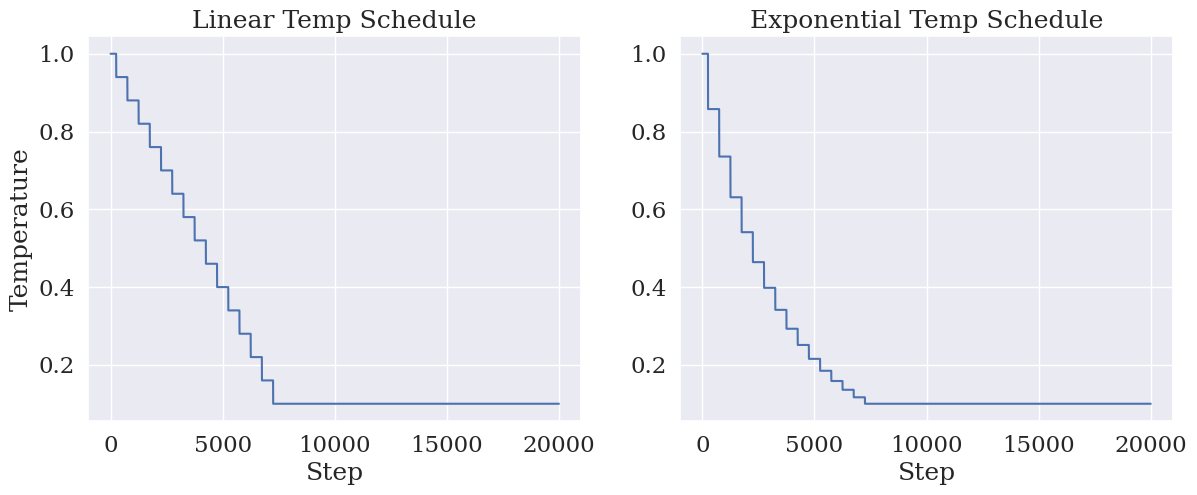

In [29]:
BATCH_SIZE = 1024
SEQ_LEN = 8
N_TRAIN_STEPS = 20000

HIGH_TEMP = 1.0
LOW_TEMP = 0.1
ROUND_FAC = 500
SCHEDULE_STEPS = 7500
ACTION_SAMPLE_TEMPERATURE = 0.01
FIX_GOAL_IN_BATCH = False


def linear_temp_schedule(step,
                         high_t = HIGH_TEMP,
                         low_t = LOW_TEMP,
                         schedule_steps = SCHEDULE_STEPS,
                         round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    return jnp.clip(high_t - (high_t - low_t) * (step / schedule_steps), low_t)


def exponential_temp_schedule(step,
                              high_t = HIGH_TEMP,
                              low_t = LOW_TEMP,
                              schedule_steps = SCHEDULE_STEPS,
                              round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    decay_fac = jnp.log(low_t / high_t) / schedule_steps
    temp = high_t * jnp.exp(decay_fac * step)
    return jnp.clip(temp, low_t, high_t)


fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(np.arange(N_TRAIN_STEPS), linear_temp_schedule(np.arange(N_TRAIN_STEPS)))
axs[0].set_title('Linear Temp Schedule')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Temperature')
axs[1].plot(np.arange(N_TRAIN_STEPS), exponential_temp_schedule(np.arange(N_TRAIN_STEPS)))
axs[1].set_title('Exponential Temp Schedule')
axs[1].set_xlabel('Step')
plt.show()


In [30]:
from flax.training.train_state import TrainState
import optax


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    temp = linear_temp_schedule(train_state.step)
    # temp = 1.0

    def compute_loss(params, batch):
        _, action_pred_logits = train_state.apply_fn(params, batch, temp=temp)
        true_actions, _, _, seq_mask = batch
        loss_mask = 1.0 - seq_mask
        loss_vals = loss_mask * categorical_cross_entropy(
            action_pred_logits, true_actions
        )
        return loss_vals.sum() / loss_mask.sum()

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_sequences(
        _rng,
        n_seqs=BATCH_SIZE,
        seq_len=SEQ_LEN,
        fix_goal_pos_in_batch=FIX_GOAL_IN_BATCH,
        action_sample_temp=ACTION_SAMPLE_TEMPERATURE
    )
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'step': train_state.step, 'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=SEQ_LEN)
obs_action_decoder = ObsActionDecoder(traj_batch.obs.shape[-1], 512)
init_params = obs_action_decoder.init(jax.random.PRNGKey(0), inputs)

optimizer = optax.adam(1e-4)
# optimizer = optax.rmsprop(1e-4)
obs_action_decoder_train_state = TrainState.create(
    apply_fn=obs_action_decoder.apply,
    params=init_params,
    tx=optimizer
)
    
(obs_action_decoder_train_state, _), metrics = jax.lax.scan(
    update_fn, (obs_action_decoder_train_state, rng), None, length=N_TRAIN_STEPS
)

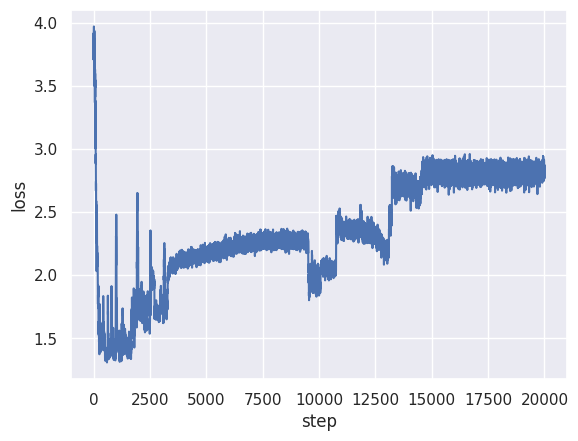

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': metrics['step']
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [33]:
rng = jax.random.PRNGKey(1)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=8, fix_goal_pos_in_batch=True)
obs_preds, action_pred_logits = obs_action_decoder.apply(obs_action_decoder_train_state.params, inputs, temp=0.1)

In [34]:
actions, messages, _, seq_mask = inputs
(1.0 - seq_mask).sum(), seq_mask.size

(Array(2896., dtype=float32), 8192)

In [ ]:
actions, messages, _, seq_mask = inputs
i = 2
ep_len = seq_mask[:, i].argmax()
print('Sequence Mask:', seq_mask[:, i], "(True = Not In Sequence)")
print('Dones:', traj_batch.done[:, i])
print('Episode Length:', ep_len)
print('True Actions:', actions[:, i].argmax(-1)[:ep_len])
print('Predicted Actions:', action_pred_logits[:, i].argmax(-1)[:ep_len])

print('Predicted Episode:')
predicted_ep = obs_preds[:, i].round(2)[:ep_len]
goal_pos, agent_pos = get_goals_and_pos(predicted_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

print('Actual Episode:')
actual_ep = traj_batch.obs[:, i].round(2)[:seq_mask[:, i].argmax()]
goal_pos, agent_pos = get_goals_and_pos(actual_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

Sequence Mask: [False False  True  True  True  True  True  True] (True = Not In Sequence)
Dones: [False  True False False  True False False False]
Episode Length: 2
True Actions: [1 1]
Predicted Actions: [1 1]
Predicted Epsiode:
---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------
|   | G |   |   |   |	|   | G |   |   |   |
---------------------	---------------------
| X |   |   |   |   |	|   | X |   |   |   |
---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------
	
Actual Episode:
---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------
|   | G |   |   |   |	|   | G |   |   |   |
---------------------	---------------------
|   |   |   |   |   |	|   | X |   |   |   |
-----

In [36]:
predicted_ep = obs_preds.round(2)
pred_goal_pos, _ = get_goals_and_pos(predicted_ep)

delta_goal_pos = jnp.abs(pred_goal_pos - traj_batch.env_state.env_state.goal_pos)
goal_pos_dist = jnp.linalg.norm(delta_goal_pos, ord=1, axis=-1)
goal_pos_dist_mean = goal_pos_dist[jnp.logical_not(seq_mask)].mean()
goal_pos_dist_std = goal_pos_dist[jnp.logical_not(seq_mask)].std()
goal_pos_dist_mean.item(), goal_pos_dist_std.item()

(0.8069751858711243, 1.437834620475769)

In [37]:
from poclaps.rollout_fake_msgs import SimpleGridWorldCommPolicy

COMM_POLICY_SEED = 0

predicted_ep = obs_preds.round(2)
goal_pos, _ = get_goals_and_pos(predicted_ep)
*batch_shape, _ = goal_pos.shape
goal_pos = goal_pos.reshape((np.prod(batch_shape), 2))

comm_policy = SimpleGridWorldCommPolicy(COMM_POLICY_SEED, env_params)

pred_msgs = jax.lax.map(
    lambda g: comm_policy.get_msg(g),
    goal_pos
)
pred_msgs = pred_msgs.reshape(batch_shape)
(pred_msgs == traj_batch.message)[jnp.logical_not(seq_mask)].mean()

Array(0.9993094, dtype=float32)

In [38]:
traj_batch.message[0, 0].item()

17

In [39]:
items = []

SEED = 0

def create_rollout_state(n_seqs, goal_pos, agent_pos, seed=0):
    reset_rng = jax.random.split(jax.random.PRNGKey(0), n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    if goal_pos.shape[0] != n_seqs:
        goal_pos = jnp.repeat(goal_pos[None], n_seqs, axis=0)
    if agent_pos.shape[0] != n_seqs:
        agent_pos = jnp.repeat(agent_pos[None], n_seqs, axis=0)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=goal_pos, agent_pos=agent_pos
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    rng = jax.random.PRNGKey(seed)
    return (env_state, obsv, rng, ep_ids)


agent_pos = jnp.array([
    [x, y]
    for x in range(env_params.grid_size)
    for y in range(env_params.grid_size)   
])

n_seqs = agent_pos.shape[0]

for x in range(env_params.grid_size):
    for y in range(env_params.grid_size):
        rng = jax.random.PRNGKey(SEED)
        rng, _rng = jax.random.split(rng)
        goal_pos = jnp.array([x, y])
        rollout_state = create_rollout_state(n_seqs, goal_pos, agent_pos, seed=SEED)
        inputs, traj_batch = sample_sequences(
            _rng,
            n_seqs=n_seqs,
            seq_len=SEQ_LEN,
            rollout_state=rollout_state,
            action_sample_temp=ACTION_SAMPLE_TEMPERATURE
        )

        init_obs = obs_action_decoder.apply(
            obs_action_decoder_train_state.params, inputs, rng,
            method=ObsActionDecoder.generate_init_obs
        )
        *batch_shape, _ = init_obs.shape
        pred_env_state = init_obs.reshape((*batch_shape, 2, 2, 5)).argmax(-1)
        pred_goal_pos = pred_env_state[:, :, 1]
        acc = jnp.logical_and(pred_goal_pos[:, 0] == x, pred_goal_pos[:, 1] == y).mean()

        items.append({'Goal X': x, 'Goal Y': y, 'Accuracy': acc})

        print(f'{x = }, {y = }: {acc:.3f}')


msg_acc_df = pd.DataFrame(items)

x = 0, y = 0: 0.000
x = 0, y = 1: 0.000
x = 0, y = 2: 0.000
x = 0, y = 3: 0.000
x = 0, y = 4: 0.000
x = 1, y = 0: 0.000
x = 1, y = 1: 0.000
x = 1, y = 2: 0.000
x = 1, y = 3: 0.000
x = 1, y = 4: 0.000
x = 2, y = 0: 0.000
x = 2, y = 1: 0.880
x = 2, y = 2: 0.040
x = 2, y = 3: 0.000
x = 2, y = 4: 0.000
x = 3, y = 0: 0.000
x = 3, y = 1: 0.040
x = 3, y = 2: 0.000
x = 3, y = 3: 0.000
x = 3, y = 4: 0.000
x = 4, y = 0: 0.000
x = 4, y = 1: 0.000
x = 4, y = 2: 0.000
x = 4, y = 3: 0.000
x = 4, y = 4: 0.000


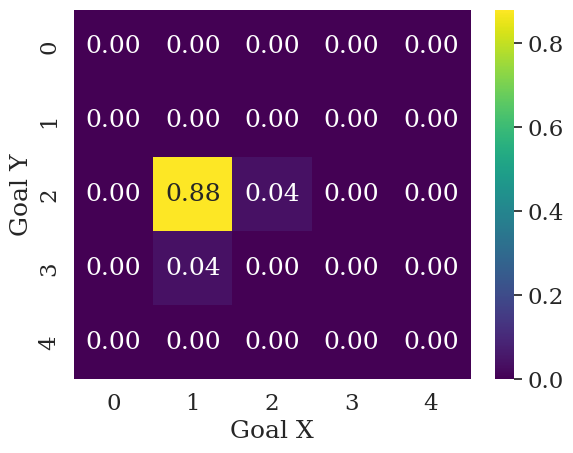

In [40]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_acc_table(msg_acc_df):

    acc_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].mean().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(acc_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True, fmt='.2f'
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


# save_reproducible_figure(
#     'goal_pos_acc_table',
#     msg_acc_df,
#     plot_acc_table,
#     show=True
# )

plot_acc_table(msg_acc_df)

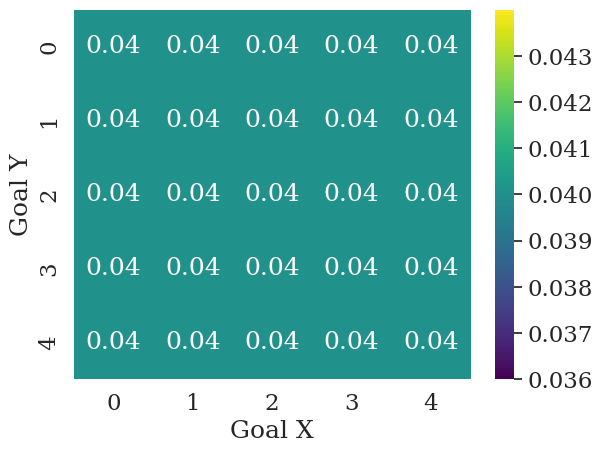

In [247]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_count_table(msg_acc_df):
    # msg_acc_df['Goal X'] = msg_acc_df['Message'] // env_params.grid_size
    # msg_acc_df['Goal Y'] = msg_acc_df['Message'] % env_params.grid_size

    count_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].count().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')
    count_table = count_table / count_table.sum().sum()

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(count_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


# save_reproducible_figure(
#     'goal_pos_count_table',
#     msg_acc_df,
#     plot_count_table,
#     show=True
# )

plot_count_table(msg_acc_df)

In [ ]:
from reproducible_figures import set_plotting_style, save_reproducible_figure


def plot_acc_table(msg_acc_df):
    msg_acc_df['Goal X'] = msg_acc_df['Message'] // env_params.grid_size
    msg_acc_df['Goal Y'] = msg_acc_df['Message'] % env_params.grid_size

    acc_table = msg_acc_df.groupby(['Goal X', 'Goal Y'])['Accuracy'].mean().reset_index().pivot(index='Goal X', columns='Goal Y', values='Accuracy')

    set_plotting_style()

    ax = sns.heatmap(
        np.float32(acc_table.to_numpy()),
        cmap='viridis', cbar=True, annot=True, fmt='.2f'
    )
    ax.set_xlabel('Goal X')
    ax.set_ylabel('Goal Y')


save_reproducible_figure(
    'goal_pos_acc_table',
    msg_acc_df,
    plot_acc_table,
    show=True
)

In [36]:
def create_rollout_state(n_seqs, goal_pos, agent_pos, seed=0):
    reset_rng = jax.random.split(jax.random.PRNGKey(0), n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(goal_pos[None], n_seqs, axis=0),
            agent_pos=jnp.repeat(agent_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    rng = jax.random.PRNGKey(seed)
    return (env_state, obsv, rng, ep_ids)

In [120]:
agent_pos = jnp.array([0, 0])
goal_pos = jnp.array([env_params.grid_size - 1, env_params.grid_size - 1])

samples = 512
rollout_state = create_rollout_state(samples, goal_pos, agent_pos)

inputs, traj_batch = sample_sequences(
    jax.random.PRNGKey(0),
    n_seqs=samples,
    seq_len=10,
    rollout_state=rollout_state
)

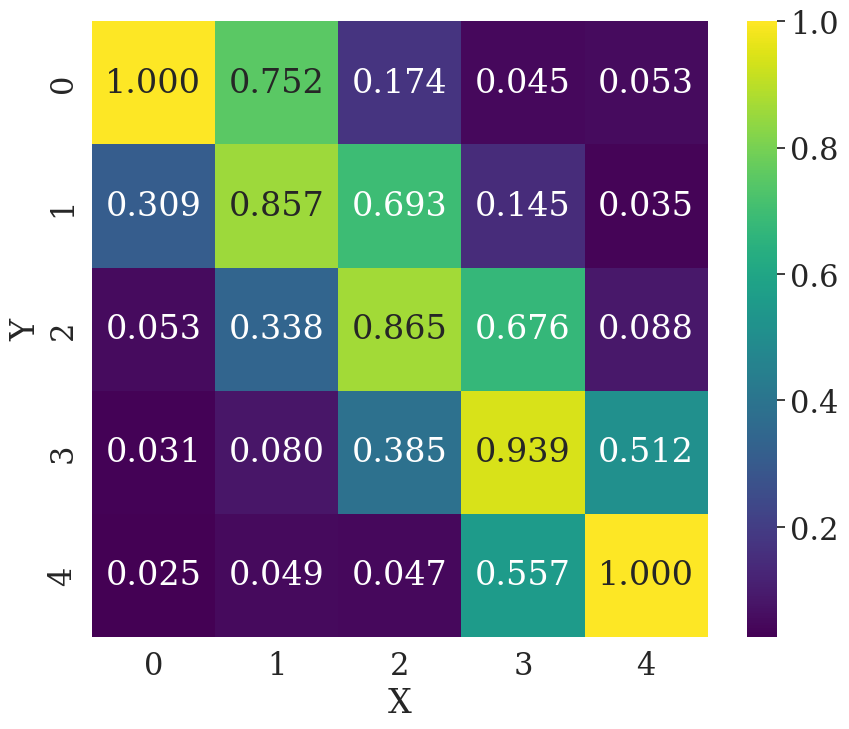

reformatted figures/prelim_run_results/agent_pos_heatmap/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [122]:
agent_pos = traj_batch.env_state.env_state.agent_pos
seq_len, n_seqs, _ = agent_pos.shape

# agent_pos = agent_pos.reshape((seq_len * n_seqs, 2))
*_, seq_mask = inputs
agent_pos = agent_pos[jnp.logical_not(seq_mask)]


agent_pos_df = pd.DataFrame(agent_pos, columns=['X', 'Y'])

def plot_policy_location_heatmap(agent_pos_df, grid_size, n_samples):
    agent_pos_df['idx'] = agent_pos_df['X'] * grid_size + agent_pos_df['Y']
    location_heatmap = agent_pos_df.groupby(['X', 'Y'])['idx'].count().reset_index().pivot(index='X', columns='Y', values='idx')
    location_heatmap[grid_size - 1][grid_size - 1] = n_samples
    location_heatmap[0][0] = n_samples

    set_plotting_style(font_scale=2)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        location_heatmap.T / n_samples,
        cmap='viridis', cbar=True,
        annot=True, fmt='.3f',
        square=True
    )


save_reproducible_figure(
    'agent_pos_heatmap',
    agent_pos_df,
    plot_policy_location_heatmap,
    show=True,
    figures_dir='figures/prelim_run_results',
    grid_size=env_params.grid_size,
    n_samples=samples
)

In [40]:
agent_pos = jnp.array([0, 0])
goal_pos = jnp.array([env_params.grid_size - 1, env_params.grid_size - 1])

samples = 512
rollout_state = create_rollout_state(samples, goal_pos, agent_pos)

dfs = []
for temp in [0.001, 0.01, 0.1, 1.0]:
    inputs, traj_batch = sample_sequences(
        jax.random.PRNGKey(0),
        n_seqs=samples,
        seq_len=10,
        rollout_state=rollout_state,
        action_sample_temp=temp
    )

    agent_pos = traj_batch.env_state.env_state.agent_pos
    seq_len, n_seqs, _ = agent_pos.shape
    *_, seq_mask = inputs
    agent_pos = agent_pos[jnp.logical_not(seq_mask)]
    df = pd.DataFrame(agent_pos, columns=['X', 'Y'])
    df['temp'] = temp
    dfs.append(df)

positions_temp_df = pd.concat(dfs)

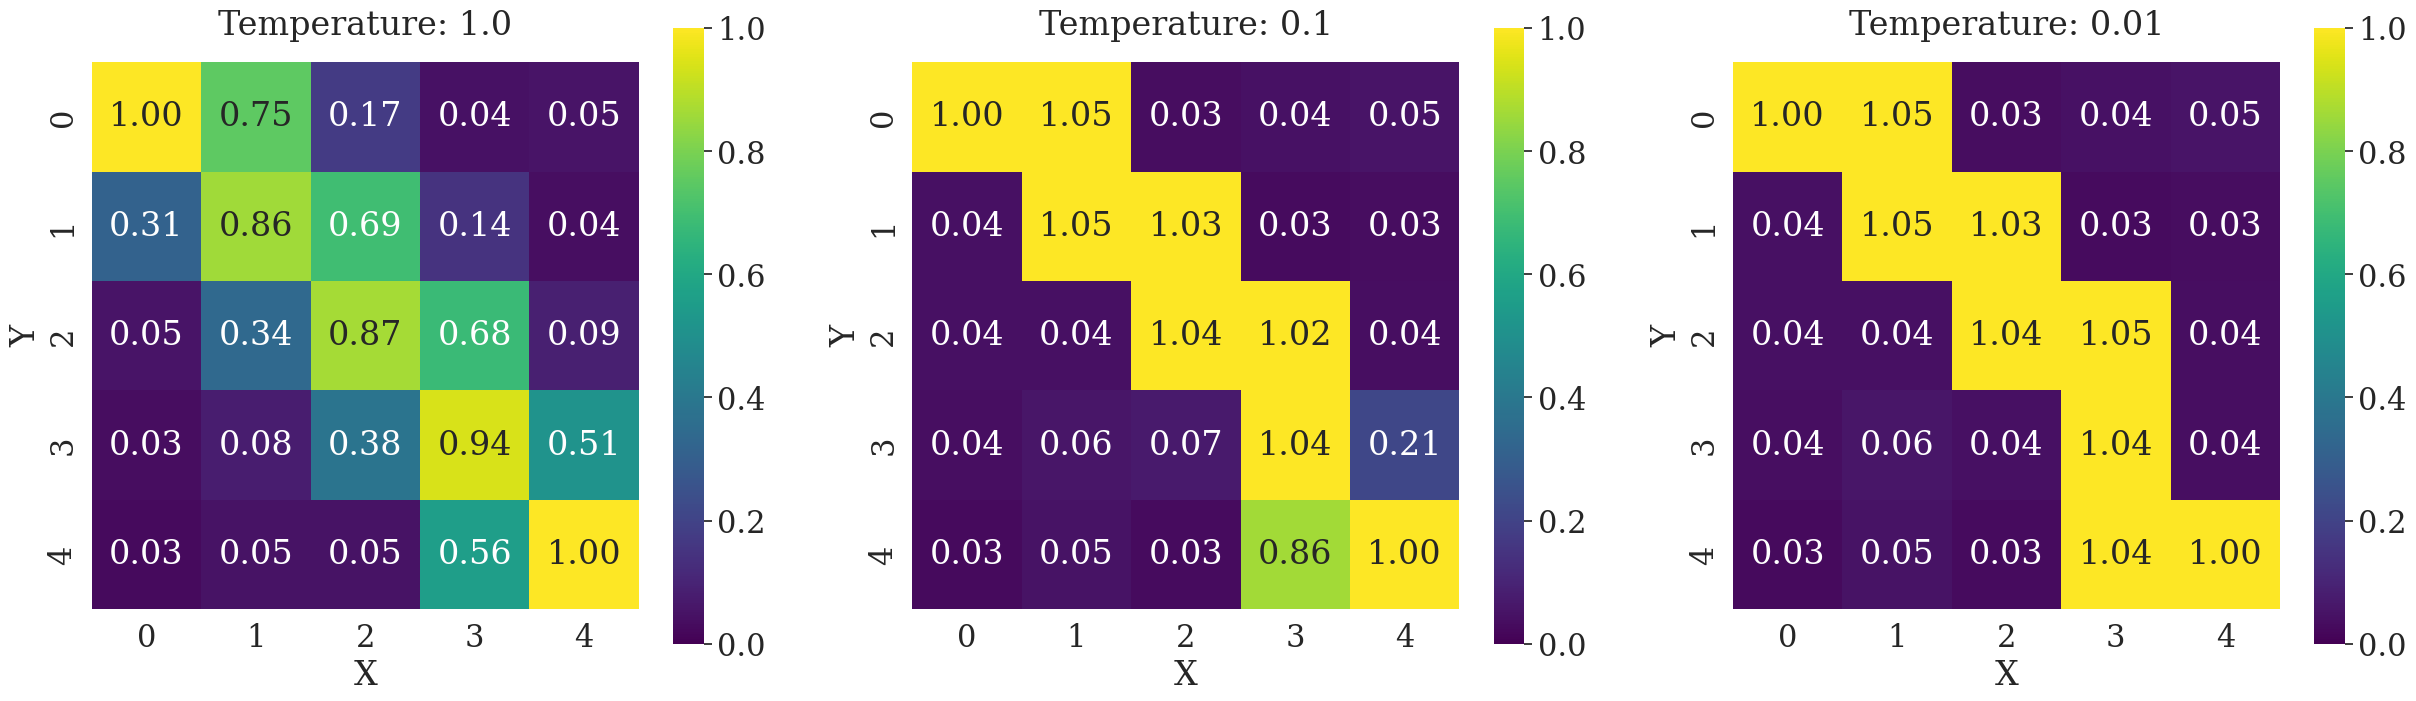

In [53]:

from numpy import pad


def plot_policy_location_heatmap(agent_pos_df, grid_size, n_samples):
    agent_pos_df['idx'] = agent_pos_df['X'] * grid_size + agent_pos_df['Y']

    set_plotting_style(font_scale=2)

    _, axs = plt.subplots(1, 3, figsize=(30, 8))
    for i, temp in enumerate([1.0, 0.1, 0.01]):
        df = agent_pos_df[agent_pos_df['temp'] == temp]
        location_heatmap = df.groupby(['X', 'Y'])['idx'].count().reset_index().pivot(index='X', columns='Y', values='idx')
        location_heatmap[grid_size - 1][grid_size - 1] = n_samples
        location_heatmap[0][0] = n_samples
        ax = axs[i]
        sns.heatmap(
            location_heatmap.T / n_samples,
            cmap='viridis', cbar=True,
            annot=True, fmt='.2f',
            square=True,
            ax=ax,
            vmin=0, vmax=1
        )
        ax.set_title(f'Temperature: {temp}', pad=20)


plot_policy_location_heatmap(positions_temp_df, env_params.grid_size, samples)

In [143]:
import distrax

t = 0.001
pi2 = distrax.Categorical(logits=pi.logits / t)

In [144]:
pi.probs.round(2)

Array([[[0.        , 0.        , 0.01      , 0.        , 0.97999996],
        [0.        , 0.        , 0.90999997, 0.09      , 0.        ],
        [0.        , 0.        , 0.95      , 0.        , 0.05      ],
        [0.        , 0.        , 0.93      , 0.06      , 0.        ]],

       [[0.        , 0.        , 0.05      , 0.        , 0.95      ],
        [0.01      , 0.        , 0.5       , 0.48999998, 0.        ],
        [0.01      , 0.        , 0.62      , 0.        , 0.37      ],
        [0.        , 0.        , 0.98999995, 0.01      , 0.        ]],

       [[0.01      , 0.        , 0.45      , 0.        , 0.53      ],
        [0.02      , 0.05      , 0.05      , 0.89      , 0.        ],
        [0.01      , 0.        , 0.95      , 0.02      , 0.02      ],
        [0.        , 0.        , 0.96      , 0.03      , 0.        ]],

       ...,

       [[0.01      , 0.01      , 0.06      , 0.90999997, 0.        ],
        [0.        , 0.06      , 0.        , 0.94      , 0.        ],
 

In [145]:
pi2.probs.round(2)

Array([[[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       ...,

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.]]], dtype=float32)

In [ ]:
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools


class RNNSeqEncoder(nn.Module):
    """
    Encodes a sequence of inputs using an RNN.
    Input of shape (T, B, D) where T is the sequence length,
    A sequence mask of shape (T, B) is used to encode the
    variable length sequences.
    A sequence [x_1, x_2, x_3, x_4] that is of length 3
    would need a mask of [False, False, False, True] to indicate that the
    last element is not part of the sequence.

    Can be used to encode each element of the sequence or the entire sequence
    by either taking the carry state or the output of the RNN.
    """
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, rnn_state, x):
        """Applies the module."""
        ins, seq_mask = x
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        new_rnn_state = jnp.where(
            seq_mask[:, np.newaxis],
            rnn_state,
            new_rnn_state,
        )
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


class ActionsMsgsEncoder(nn.Module):
    enc_size: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        actions, msgs, rng, seq_mask = inputs
        feats = jnp.concatenate([actions, msgs], axis=-1)

        x = nn.Dense(self.hidden_size)(feats)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)

        _, n_envs, _ = x.shape
        init_carry = RNNSeqEncoder.initialize_carry(n_envs, self.hidden_size)
        # _, x = ScannedRNN(self.hidden_size)(init_carry, (x, seq_mask))
        enc, _ = RNNSeqEncoder(self.hidden_size)(init_carry, (x, seq_mask))

        return nn.Dense(self.enc_size)(enc)



from tensorflow_probability.substrates import jax as tfp


def relaxed_sample_obs(logits, rng, temp=0.1):
    *batch_shape, _ = logits.shape
    env_states_logits = logits.reshape((
        *batch_shape, 2, 2, env_params.grid_size
    ))

    if len(batch_shape) == 1:
        agent_pos_x_logits = env_states_logits[:, 0, 0]
        agent_pos_y_logits = env_states_logits[:, 0, 1]
        goal_pos_x_logits = env_states_logits[:, 1, 0]
        goal_pos_y_logits = env_states_logits[:, 1, 1]
    elif len(batch_shape) == 2:
        agent_pos_x_logits = env_states_logits[:, :, 0, 0]
        agent_pos_y_logits = env_states_logits[:, :, 0, 1]
        goal_pos_x_logits = env_states_logits[:, :, 1, 0]
        goal_pos_y_logits = env_states_logits[:, :, 1, 1]


    agent_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_x = agent_x_dist.sample(seed=_rng)

    agent_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_y = agent_y_dist.sample(seed=_rng)

    goal_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_x = goal_x_dist.sample(seed=_rng)

    goal_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_y = goal_y_dist.sample(seed=_rng)

    return jnp.concatenate(
        [agent_pos_x, agent_pos_y, goal_pos_x, goal_pos_y],
        axis=-1
    )


class ObsDecoder(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, act_msg_enc, inputs, temp: float = 0.1):
        """
        Args:
            x: (B, D)
        """
        actions, msgs, rng, seq_mask = inputs
        x = jnp.concatenate([
            actions, msgs,
            jnp.repeat(act_msg_enc[None], actions.shape[0], axis=0)
        ], axis=-1)

        _, n_envs, _ = x.shape
        init_carry = RNNSeqEncoder.initialize_carry(n_envs, self.hidden_dim)
        _, x = RNNSeqEncoder(self.hidden_dim)(init_carry, (x, seq_mask))

        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        # x = nn.Dropout(0.5)(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return relaxed_sample_obs(x, rng, temp=temp)


class ObsActionRNNDecoder(nn.Module):
    obs_dim: int
    hidden_size: int = 512

    def setup(self):
        self.act_msg_encoder = ActionsMsgsEncoder(self.hidden_size, self.hidden_size)
        self.obs_decoder = ObsDecoder(self.obs_dim, self.hidden_size)

    def __call__(self, inputs, temp: float = 0.1):
        act_msg_enc = self.act_msg_encoder(inputs)
        obs_preds = self.obs_decoder(act_msg_enc, inputs, temp=temp)
        return obs_preds

In [ ]:
obs_act_rnn_decoder = ObsActionRNNDecoder(traj_batch.obs.shape[-1], 512)
inputs, traj_batch = sample_sequences(jax.random.PRNGKey(0), n_seqs=1024, seq_len=4)
oa_rnn_decoder_params = obs_act_rnn_decoder.init(jax.random.PRNGKey(0), inputs)

In [76]:
obs_preds = obs_act_rnn_decoder.apply(oa_rnn_decoder_params, inputs, temp=0.5)

In [77]:
obs_preds.shape

(4, 1024, 20)

In [78]:
obs_preds[:, 0].round(2)

Array([[0.02      , 0.        , 0.88      , 0.        , 0.09      ,
        0.        , 0.12      , 0.07      , 0.64      , 0.17      ,
        0.17      , 0.04      , 0.65      , 0.06      , 0.09      ,
        0.58      , 0.02      , 0.11      , 0.26999998, 0.02      ],
       [0.        , 0.02      , 0.01      , 0.        , 0.96      ,
        0.        , 0.        , 0.98999995, 0.        , 0.01      ,
        0.01      , 0.53      , 0.13      , 0.02      , 0.31      ,
        0.01      , 0.26999998, 0.32      , 0.28      , 0.12      ],
       [0.35999998, 0.05      , 0.04      , 0.01      , 0.55      ,
        0.03      , 0.68      , 0.14999999, 0.01      , 0.14      ,
        0.        , 0.01      , 0.        , 0.76      , 0.22      ,
        0.        , 0.25      , 0.01      , 0.16      , 0.57      ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.74      , 0.17999999, 0.06      , 0.01      , 0.01      ,
        0.01      , 0.        , 0.85999995, 0

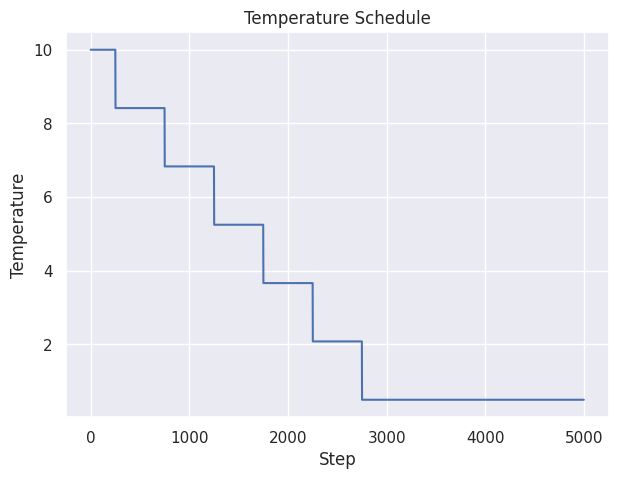

Running Training Loop...


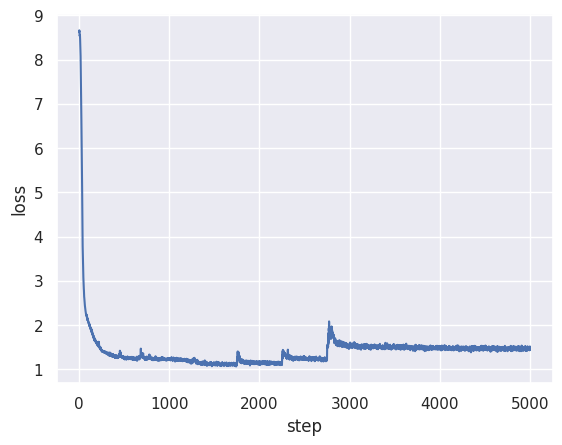

In [191]:
BATCH_SIZE = 1024
SEQ_LEN = 8
N_TRAIN_STEPS = 5000

HIGH_TEMP = 10.0
LOW_TEMP = 0.5
ROUND_FAC = 500
SCHEDULE_STEPS = 3000
ACTION_SAMPLE_TEMPERATURE = 0.01
FIX_GOAL_IN_BATCH = False
ACTION_PRED_LOSS_FACTOR = 1.0
OBS_PRED_LOSS_FACTOR = 0.5


def linear_temp_schedule(step,
                         high_t = HIGH_TEMP,
                         low_t = LOW_TEMP,
                         schedule_steps = SCHEDULE_STEPS,
                         round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    return jnp.clip(high_t - (high_t - low_t) * (step / schedule_steps), low_t)


def exponential_temp_schedule(step,
                              high_t = HIGH_TEMP,
                              low_t = LOW_TEMP,
                              schedule_steps = SCHEDULE_STEPS,
                              round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    decay_fac = jnp.log(low_t / high_t) / schedule_steps
    temp = high_t * jnp.exp(decay_fac * step)
    return jnp.clip(temp, low_t, high_t)


temp_schedule = linear_temp_schedule

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(np.arange(N_TRAIN_STEPS), temp_schedule(np.arange(N_TRAIN_STEPS)))
ax.set_title('Temperature Schedule')
ax.set_xlabel('Step')
ax.set_ylabel('Temperature')
plt.show()


from flax.training.train_state import TrainState
import optax


def decoding_actions_loss_fn(inputs, obs_preds):
    pi, *_ = pretrained_policy(obs_preds)
    true_actions, _, _, seq_mask = inputs
    loss_mask = 1.0 - seq_mask
    loss_vals = loss_mask * categorical_cross_entropy(
        pi.logits, true_actions
    )
    return loss_vals.sum() / loss_mask.sum()


def obs_transition_loss(inputs, obs_preds):
    true_actions, _, _, seq_mask = inputs
    pred_next_obs_logits = transition_model.apply(
        transition_model_train_state.params,
        (true_actions[:-1], obs_preds[:-1])
    )
    loss_mask = 1.0 - seq_mask[:-1]
    loss_vals = loss_mask * obs_loss_fn(obs_preds[1:], pred_next_obs_logits)
    return loss_vals.sum() / loss_mask.sum()


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    temp = temp_schedule(train_state.step)

    def compute_loss(params, batch):
        obs_preds = train_state.apply_fn(params, batch, temp=temp)
        loss_a = decoding_actions_loss_fn(batch, obs_preds)
        loss_o = obs_transition_loss(batch, obs_preds)
        return ACTION_PRED_LOSS_FACTOR * loss_a + OBS_PRED_LOSS_FACTOR * loss_o, (loss_a, loss_o)

    rng, _rng = jax.random.split(rng)
    batch, _ = sample_sequences(
        _rng,
        n_seqs=BATCH_SIZE,
        seq_len=SEQ_LEN,
        fix_goal_pos_in_batch=FIX_GOAL_IN_BATCH,
        action_sample_temp=ACTION_SAMPLE_TEMPERATURE
    )
    grad_loss_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, (loss_a, loss_o)), grads = grad_loss_fn(
        train_state.params, batch
    )
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {
        'step': train_state.step,
        'loss': loss, 'loss_a': loss_a, 'loss_o': loss_o
    }
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_sequences(_rng, n_seqs=BATCH_SIZE, seq_len=SEQ_LEN)
obs_act_rnn_decoder = ObsActionRNNDecoder(traj_batch.obs.shape[-1], 512)
rng, _rng = jax.random.split(rng)
init_params = obs_act_rnn_decoder.init(_rng, inputs)

optimizer = optax.adam(1e-4)
oa_rnn_decoder_train_state = TrainState.create(
    apply_fn=obs_act_rnn_decoder.apply,
    params=init_params,
    tx=optimizer
)

print('Running Training Loop...')

(oa_rnn_decoder_train_state, _), metrics = jax.lax.scan(
    update_fn, (oa_rnn_decoder_train_state, rng), None, length=N_TRAIN_STEPS
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': metrics['step']
})

sns.lineplot(df, x='step', y='loss')
plt.show()

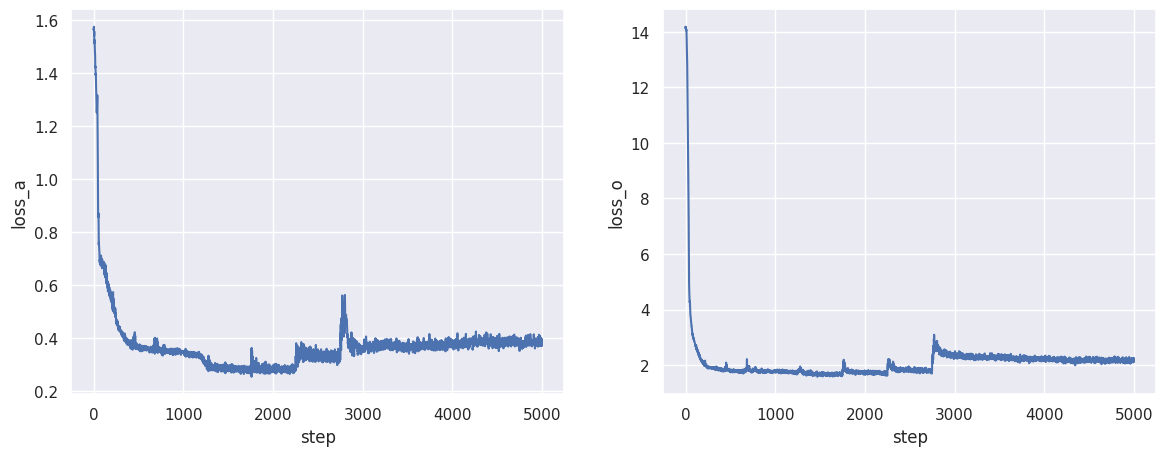

In [192]:
df = pd.DataFrame({
    'loss': metrics['loss'],
    'loss_o': metrics['loss_o'],
    'loss_a': metrics['loss_a'],
    'step': metrics['step'],
})

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.lineplot(df, x='step', y='loss_a', ax=ax1)
sns.lineplot(df, x='step', y='loss_o', ax=ax2)
plt.show()

In [193]:
inputs, traj_batch = sample_sequences(
    rng,
    n_seqs=BATCH_SIZE,
    seq_len=SEQ_LEN,
    fix_goal_pos_in_batch=FIX_GOAL_IN_BATCH,
    action_sample_temp=ACTION_SAMPLE_TEMPERATURE
)
actions, messages, _, seq_mask = inputs

In [194]:
obs_preds = obs_act_rnn_decoder.apply(oa_rnn_decoder_train_state.params, inputs, temp=0.5)

pi, *_ = pretrained_policy(obs_preds)
true_actions, _, _, seq_mask = inputs
loss_mask = 1.0 - seq_mask
loss_vals = loss_mask * categorical_cross_entropy(
    pi.logits, true_actions
)

loss_vals.sum() / loss_mask.sum()

Array(0.3781582, dtype=float32)

In [197]:
obs_preds = obs_act_rnn_decoder.apply(oa_rnn_decoder_train_state.params, inputs, temp=0.1)
pi, *_ = pretrained_policy(obs_preds)
i = 16
ep_len = seq_mask[:, i].argmax()
print('Sequence Mask:', seq_mask[:, i], "(True = Not In Sequence)")
print('Dones:', traj_batch.done[:, i])
print('Episode Length:', ep_len)
print('True Actions:', actions[:, i].argmax(-1)[:ep_len])
print('Predicted Actions:', pi.logits[:, i].argmax(-1)[:ep_len])

print('Predicted Epsiode:')
predicted_ep = obs_preds[:, i].round(2)[:ep_len]
goal_pos, agent_pos = get_goals_and_pos(predicted_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

print('Actual Episode:')
actual_ep = traj_batch.obs[:, i].round(2)[:seq_mask[:, i].argmax()]
goal_pos, agent_pos = get_goals_and_pos(actual_ep[:, np.newaxis])
print_episode(goal_pos[:, 0].tolist(), agent_pos[:, 0].tolist())

Sequence Mask: [False False False False  True  True  True  True] (True = Not In Sequence)
Dones: [False False False  True False False False False]
Episode Length: 4
True Actions: [2 3 3 2]
Predicted Actions: [2 3 3 2]
Predicted Epsiode:
---------------------	---------------------	---------------------	---------------------
|   |   |   | X |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   | X |   |	|   |   |   | X |   |	|   |   | X |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   | G |   |   |	|   |   | G |   |   |	|   |   | G |   |   |	|   |   | G |   |   |
---------------------	---------------------	---------------------	---------------------
|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |	|   |   |   |   |   |
---------------------	---------------------	---------------